In [23]:
%matplotlib inline
%config IPython.matplotlib.backend = 'retina'
%config InlineBackend.figure_format = 'retina'

In [24]:
import matplotlib
import matplotlib.pyplot as plt
from cycler import cycler
matplotlib.rc("font", family="serif", size=14)
#matplotlib.rc("figure", figsize="10, 5")
colors = ['k', 'c', 'm', 'y']
matplotlib.rc('axes', prop_cycle=cycler("color", colors))

import scipy.optimize
import numpy as np

# Example: Fitting a line to data
Our model will consist of a set of  NN  i.i.d. observations, including: a coordinate (fixed parameter)  xixi , a noise level  σiσi , and observed variable  ŷ iy^i  drawn from a Gaussian with mean  mxi+bmxi+b  and variance  σ2iσi2 , i.e.  ŷ i∼(mxi+b;σ2i)y^i∼N(mxi+b;σi2) .

## generate a model:

In [25]:
slope_true = np.random.uniform(0, 1)
intercept_true = np.random.uniform(0, 1)
print('Slopes:', slope_true)
print('Intercepts:', intercept_true)
# This notebook is ready for you to play with 2+ components and more complicated models.

Slopes: 0.760292197390898
Intercepts: 0.22579349625822198


## generate some data drawn from that model:

In [26]:
ndatapoints = 20
xis_true = np.random.uniform(0, 1, ndatapoints)
x_grid = np.linspace(0, 1, 100)


def model_linear(xs, slope, intercept): return xs * slope + intercept
yis_true = model_linear(xis_true, slope_true, intercept_true)

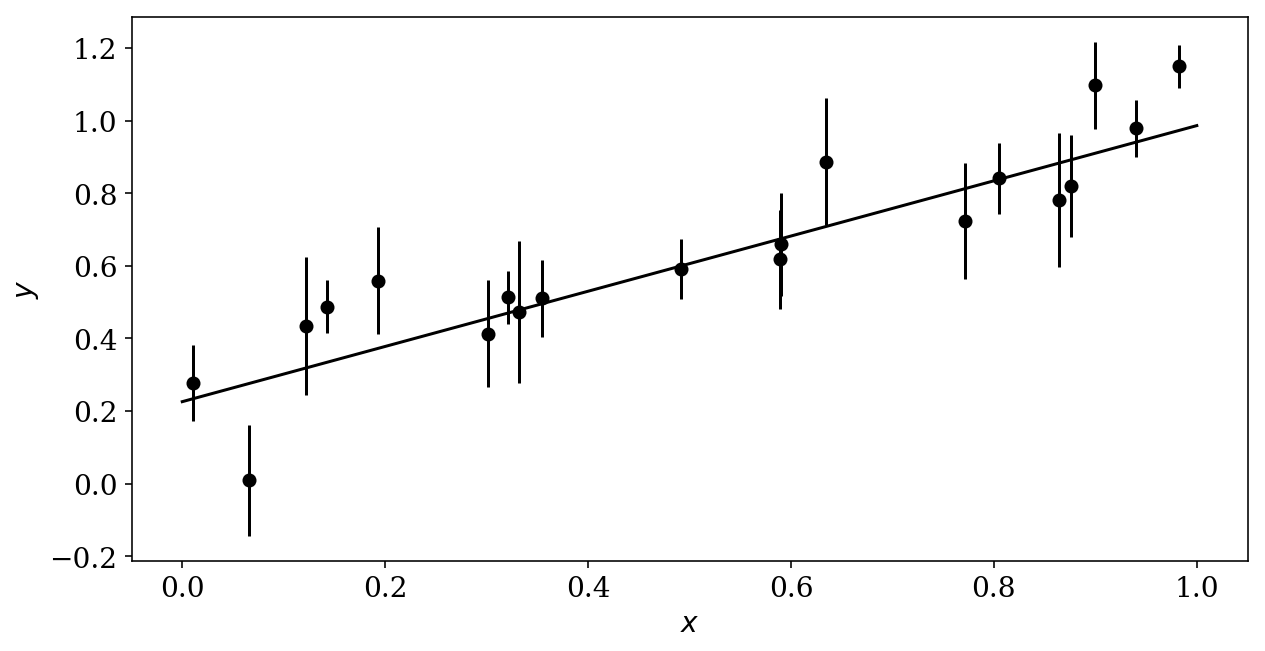

In [27]:
ndatapoints = 20
xis_true = np.random.uniform(0, 1, ndatapoints)
x_grid = np.linspace(0, 1, 100)

def model_linear(xs, slope, intercept): return xs * slope + intercept
yis_true = model_linear(xis_true, slope_true, intercept_true)

sigma_yis = np.repeat(0.1, ndatapoints) * np.random.uniform(0.5, 2.0, ndatapoints)
yis_noisy = yis_true + np.random.randn(ndatapoints) * sigma_yis

y_min, y_max = np.min(yis_noisy - sigma_yis), np.max(yis_noisy + sigma_yis)
y_min = np.min([y_min, np.min(model_linear(x_grid, slope_true, intercept_true))])
y_max = np.max([y_max, np.max(model_linear(x_grid, slope_true, intercept_true))])

plt.figure(figsize=(10, 5))
plt.plot(x_grid, model_linear(x_grid, slope_true, intercept_true), c=colors[0])
plt.errorbar(xis_true, yis_noisy, sigma_yis, fmt='o', c=colors[0])
plt.xlabel('$x$'); plt.ylabel('$y$');# plt.ylim([y_min, y_max])

## Pretend we don't know the model

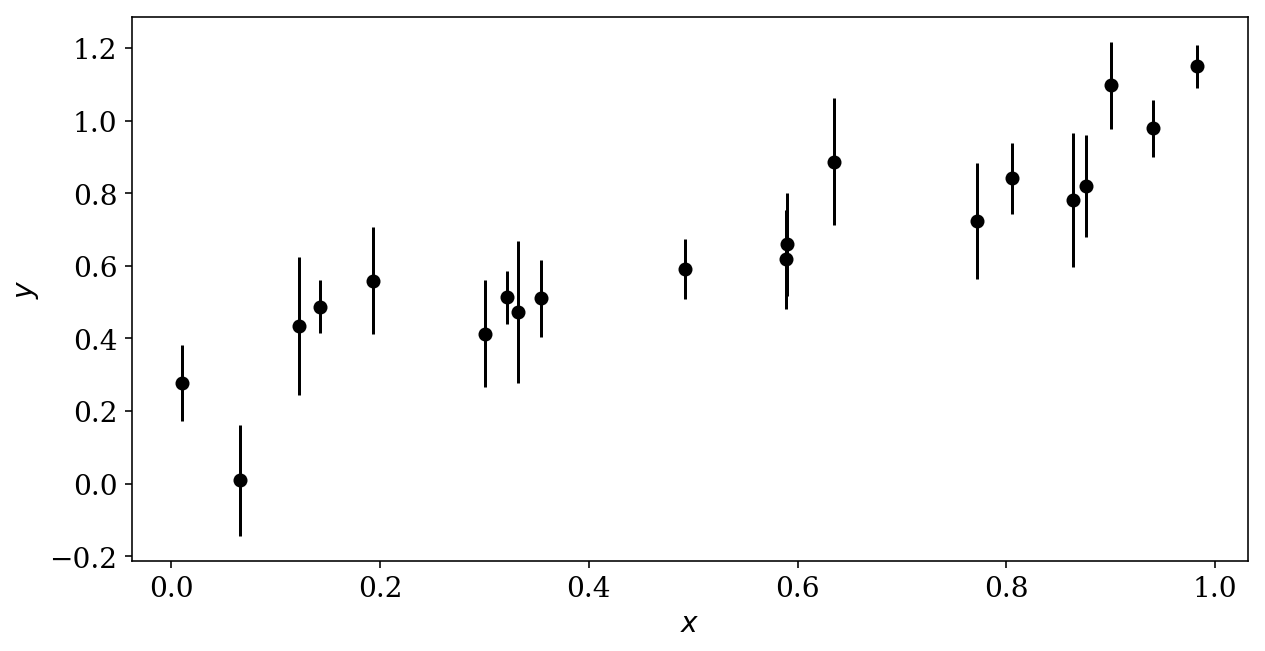

In [28]:
y_min, y_max = 0, 1
plt.figure(figsize=(10, 5))
plt.errorbar(xis_true, yis_noisy, sigma_yis, fmt='o')
plt.xlabel('$x$'); plt.ylabel('$y$'); #plt.ylim([y_min, y_max])

## What do we need to use MCMC to find?

### Bayes Theorem

$$p\bigl(m, b \ \bigl\vert \ \{ \hat{y}_i, \sigma_i, x_i\} \bigr) \ \propto \ p\bigl(\{ \hat{y}_i \} \ \bigl\vert \ m, b, \{\sigma_i, x_i\}\bigr) \  p\bigl(m, b\bigr) $$

We want to know how the parameters m and b are distributed given the data

### Likelihood

$$\begin{align}
p\bigl(\{ \hat{y}_i \} \ \bigl\vert \ m, b, \{\sigma_i, x_i\}\bigr) &\ = \prod_{i=1}^{N} p(\hat{y}_i \vert x_i, \sigma_i, b, m)\\
&\ = \prod_{i=1}^{N} \mathcal{N}\left(\hat{y}_i - m x_i - b; \sigma^2_i \right) \\
&\ = \prod_{i=1}^{N} \frac{1}{\sqrt{2\pi}\sigma_i}\exp\left( - \frac{1}{2} \frac{(\hat{y}_i - m x_i - b)^2}{\sigma^2_i} \right)  \\
&\ \propto \ \exp\left( - \sum_{i=1}^{N} \frac{1}{2} \frac{(\hat{y}_i - m x_i - b)^2}{\sigma^2_i} \right) \
\end{align}
$$

Since the data points are independent and the noise is Gaussian.

use log posterior, increases in same way and is numerically more managable

In [29]:
def ln_like(params, xs, observed_yis, yi_uncertainties):
    model_yis = model_linear(xs, params[0], params[1])
    chi2s = ((observed_yis - model_yis) / yi_uncertainties)**2
    return np.sum(-0.5 * chi2s - 0.5*np.log(2*np.pi) - np.log(yi_uncertainties))

def ln_prior(params):
    if np.any(params < 0) or np.any(params > 1):
        return - np.inf
    return 0.

def ln_post(params, xs, observed_yis, yi_uncertainties):
    lnprior_val = ln_prior(params)
    if ~np.isfinite(lnprior_val):
        return lnprior_val
    else:           
        lnlike_val = ln_like(params, xs, observed_yis, yi_uncertainties)
        return lnprior_val + lnlike_val

In [30]:
x0 = np.array([0.5, 0.5])
print('Likelihood:', ln_like(x0, xis_true, yis_noisy, sigma_yis))
print('Prior:', ln_prior(x0))
print('Posterior:', ln_post(x0, xis_true, yis_noisy, sigma_yis))

Likelihood: 0.718904638822
Prior: 0.0
Posterior: 0.718904638822


## The Metropolis-Hastings algorithm

For a given target probability $p(\theta)$ and a (symmetric) proposal distribution $p(\theta_{i+1}|\theta_i)$. We repeat the following: 
- draw a sample $\theta_{i+1}$ given $\theta_i$ from the proposal distribution, 
- compute the acceptance probability ratio $a={p(\theta_{i+1})}/{p(\theta_i)}$, 
- draw a random uniform number $r$ in $[0, 1]$ and accept $\theta_{i+1}$ if $r < a$.

In [31]:
num_draws = 1000
params_drawn = np.zeros((num_draws, 2))
i_draw = 1
num_draws_tot = 0
params_drawn[0, :] = np.random.uniform(0, 1, 2)
while i_draw < num_draws:
    num_draws_tot += 1
    params_drawn[i_draw, :] = params_drawn[i_draw-1, :] \
        + 0.05 * np.random.randn(2)
    a = np.exp(ln_post(params_drawn[i_draw, :], xis_true, yis_noisy, sigma_yis)\
                   - ln_post(params_drawn[i_draw-1, :], xis_true, yis_noisy, sigma_yis))
    if a >= 1 or np.random.uniform(0, 1, 1) < a:
        i_draw += 1
print('Acceptance rate:', num_draws/num_draws_tot)

Acceptance rate: 0.39635354736424894


(0.0, 1.0)

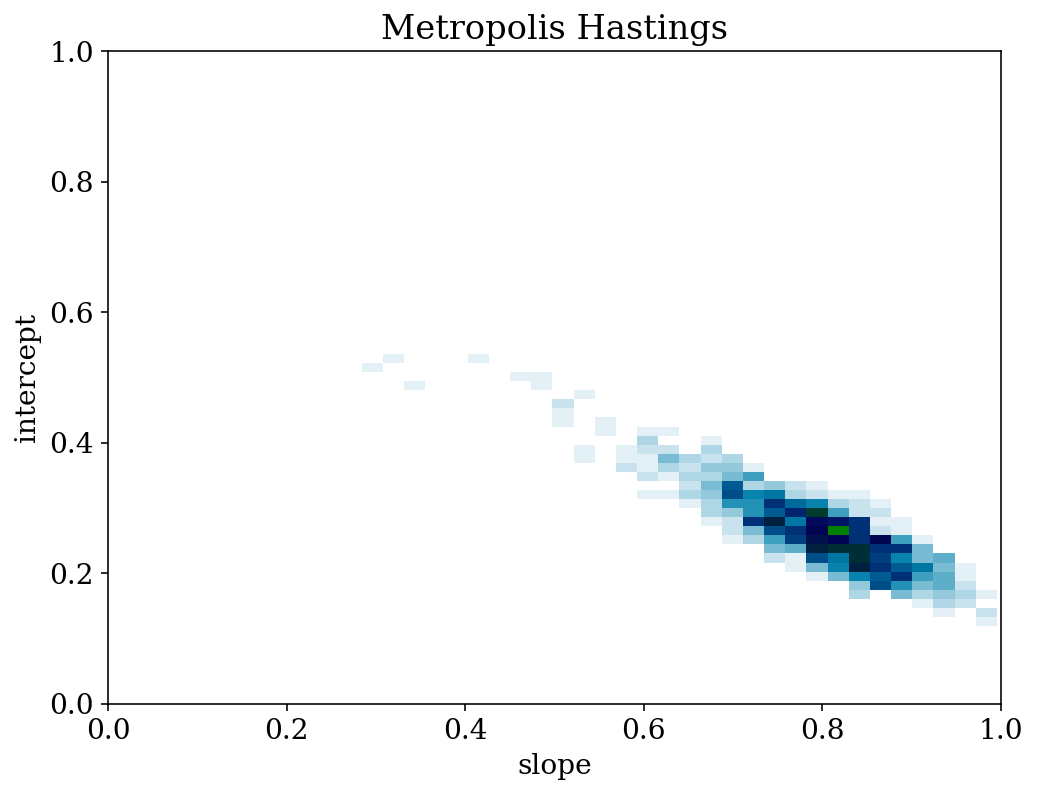

In [32]:
fig, axs = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(8,6))
axs.hist2d(params_drawn[:, 0], params_drawn[:, 1], 30, cmap="ocean_r");
axs.set_title('Metropolis Hastings'); 
axs.set_xlabel('slope'); axs.set_ylabel('intercept');
axs.set_xlim(0.0,1.0)
axs.set_ylim(0.0, 1.0)

Visualise the chains:

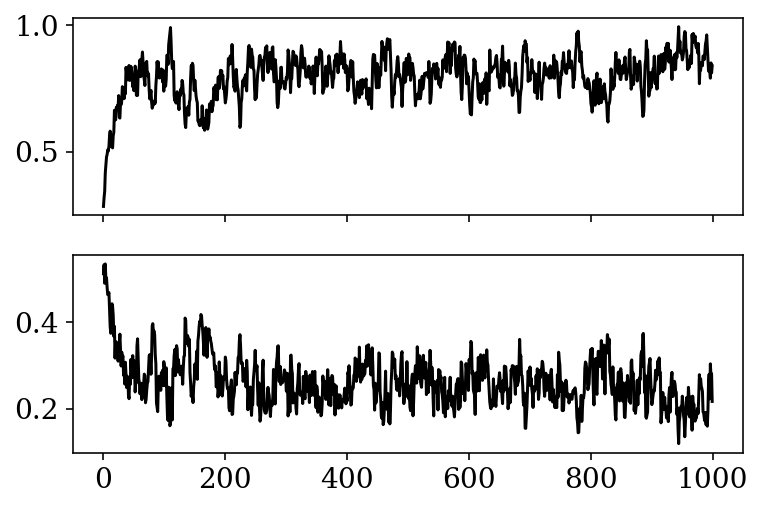

In [33]:
fig, ax = plt.subplots(2, sharex=True)
for i in range(2):
    ax[i].plot(params_drawn[:, i]);

Has the chain converged?
What is the acceptance fraction?

Choices: proposal distribution, starting point, number of steps